# Test with real SCADA data

In [1]:
import logging
import os
from pathlib import Path

from dotenv import load_dotenv

import gpytorch

from matplotlib import pyplot as plt

import numpy as np

import pandas as pd

import seaborn as sns

import torch

import xarray as xr


%load_ext autoreload
%autoreload 2

# Logger
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)s: %(message)s',
    level=logging.INFO,
    datefmt='%I:%M:%S'
)

# Load dotenv
_ = load_dotenv()


# DEFAULT
DATA_FOLDER = Path(os.getenv('BASE')) / 'data'

In [2]:
from gp_sand.gp import SparseHSGPRegressor

from sklearn.preprocessing import MinMaxScaler

## Load data

In [3]:
ds = (
    xr.load_dataset(DATA_FOLDER / 'turb.nc')
    .pipe(lambda ds: (
        ds.assign(ws_norm=ds['ws_corr'] / 10)
    ))
    .pipe(lambda ds: (
        ds.assign(
            is_analysis=(
                ds['normal_op']
                & ds['no_close_wake']
                & (ds['gen_speed_norm'] <= 0.95)
                & (.2 <= ds['gen_speed_norm'])
                # & ('power')
            )
        )
    ))
)
ds

<xarray.Dataset> Size: 2GB
Dimensions:               (wt: 118, time: 51689)
Coordinates:
  * wt                    (wt) <U7 3kB 'WTG-001' 'WTG-002' ... 'WTG-118'
  * time                  (time) datetime64[ns] 414kB 2022-02-06T06:00:00 ......
Data variables: (12/52)
    ws_avg                (wt, time) float64 49MB 3.305 3.569 ... 9.381 10.65
    ws_std                (wt, time) float64 49MB 1.114 0.899 ... 1.505 1.497
    nac_pos_avg           (wt, time) float64 49MB 225.6 249.0 ... 182.0 182.0
    yaw_err_avg           (wt, time) float64 49MB 7.717 -1.323 ... 18.36 19.62
    power_avg             (wt, time) float64 49MB 76.65 66.91 ... -2.413 -2.501
    gen_speed_avg         (wt, time) float64 49MB 860.7 809.9 ... 0.0 0.0002481
    ...                    ...
    wd_y                  (wt, time) float64 49MB 0.9929 0.8638 ... 0.7031
    wd_x_cons             (time, wt) float64 49MB 0.4788 0.6749 ... 0.7818
    wd_y_cons             (time, wt) float64 49MB 0.7701 0.6562 ... 0.6177
    wd_cons               (time, wt) float64 49MB 211.9 225.8 ... 232.2 231.7
    ws_norm               (time, wt) float64 49MB 0.4108 0.4624 ... 0.8634
    is_analysis           (wt, time) bool 6MB False False False ... False False

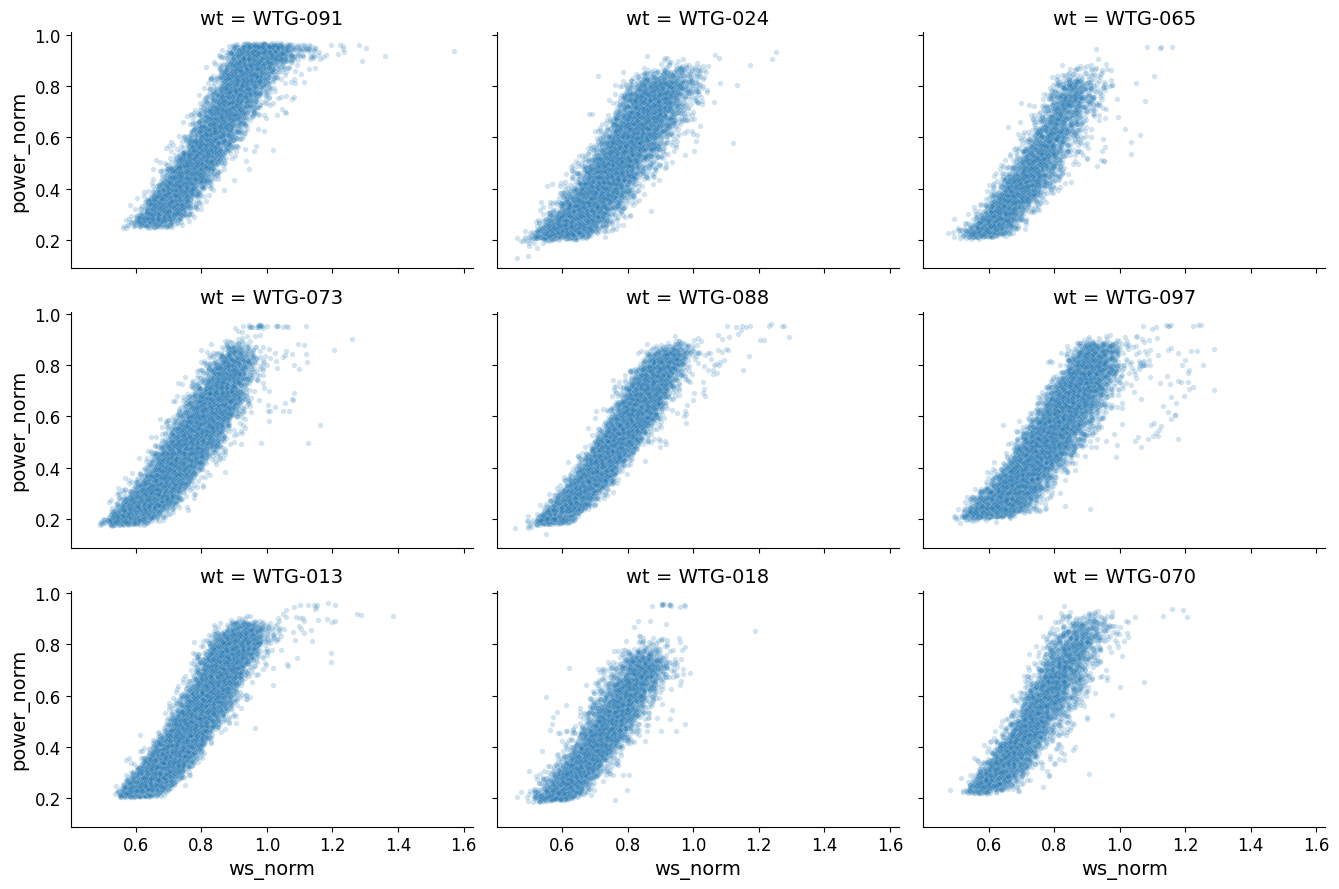

In [4]:
data = (
    ds
    .where(ds['is_analysis'])
    .sel(wt=np.random.choice(
        ds['wt'].data,
        size=9,
        replace=False,
    ))
    .to_dataframe()
    .dropna()
    .reset_index()
)
data

g = sns.relplot(
    kind='scatter',
    data=data,
    x='ws_norm',
    y='power_norm',
    col='wt',
    col_wrap=3,
    height=3,
    aspect=1.5,
    s=15,
    alpha=.2,
)

## Pipeline

### Slice data

In [5]:
wt = 'WTG-002'

df = (
    ds
    # .where(
    #     ds['time'] <= pd.Timestamp('2022-07-01'),
    #     drop=True,
    # )
    .where(ds['is_analysis'])
    .sel(wt=wt)
    .to_dataframe()
    .dropna()
    .reset_index()
)
df



,time,ws_avg,ws_std,nac_pos_avg,yaw_err_avg,power_avg,gen_speed_avg,pitchb1_avg,pitchb2_avg,pitchb3_avg,...,ws_std_corr,unit_ws,wd_x,wd_y,wd_x_cons,wd_y_cons,wd_cons,ws_norm,is_analysis,wt
0,2022-02-06 11:10:00,8.309117,1.604614,37.934605,0.341667,1348.87650,1352.8320,0.559134,-0.428020,-0.031780,...,1.539071,1.0,0.999899,0.014231,0.819866,-0.255676,287.320122,0.940652,1.0,WTG-002
1,2022-02-06 11:20:00,8.413156,1.576859,39.022877,-3.356667,1486.11500,1399.4746,0.780675,-0.223394,0.174654,...,1.512450,1.0,0.999989,-0.004763,0.823806,-0.257440,287.354075,0.933378,1.0,WTG-002
2,2022-02-06 22:50:00,9.077025,1.688494,52.755253,-1.848333,1497.70390,1386.2311,1.141471,0.120677,0.532721,...,1.619525,1.0,0.970274,-0.242011,0.760994,-0.435091,299.758316,0.878527,1.0,WTG-002
3,2022-02-06 23:00:00,8.893195,1.469310,48.530930,-2.988333,1491.37550,1397.6958,0.931530,-0.065480,0.330840,...,1.409294,1.0,0.985464,-0.169882,0.830360,-0.453492,298.640694,0.858443,1.0,WTG-002
4,2022-02-06 23:10:00,8.850723,1.695654,44.675884,-2.618333,1431.40090,1372.3331,1.004840,-0.003507,0.402019,...,1.626392,1.0,0.994656,-0.103242,0.787537,-0.355938,294.321211,0.881544,1.0,WTG-002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14810,2023-01-31 11:50:00,8.446057,1.107435,30.003527,-2.018333,1244.32760,1287.9036,0.129323,-0.586498,-0.557402,...,1.062200,1.0,0.997979,-0.063549,0.980433,-0.069227,274.038862,0.832230,1.0,WTG-002
14811,2023-01-31 12:00:00,9.300501,1.127704,30.404142,-1.433333,1301.24230,1307.3542,0.129323,-0.586498,-0.557402,...,1.081641,1.0,0.997510,-0.070526,0.980407,-0.072719,274.241970,0.880622,1.0,WTG-002
14812,2023-01-31 12:10:00,8.931801,0.972793,32.216465,-1.635000,997.44147,1198.7733,0.129323,-0.586498,-0.557402,...,0.933057,1.0,0.994781,-0.102037,0.977709,-0.085567,275.001676,0.835242,1.0,WTG-002
14813,2023-01-31 14:20:00,6.716604,0.965405,14.709318,0.600000,602.57764,1022.4294,-0.037438,-0.618735,-0.427704,...,0.925972,1.0,0.979397,0.201944,0.969473,0.143308,261.591429,0.689331,1.0,WTG-002


### Regressor for power

In [6]:
features = ['ws_norm', 'ws_std_corr', 'temp_amb_cons']
target = 'power_norm'

model = SparseHSGPRegressor(
    n_pts=150,
    # objective='elbo',
    preprocessor=MinMaxScaler(),
    n_epochs=150,
)

In [7]:
model.fit(
    df[features].values,
    df[target].values
)

BITE


07:55:34 INFO: Iter 10 of 150 - Loss: 0.47803276777267456
07:55:36 INFO: Iter 20 of 150 - Loss: 0.01574404165148735
07:55:38 INFO: Iter 30 of 150 - Loss: -0.4629161059856415
07:55:39 INFO: Iter 40 of 150 - Loss: -0.8650779128074646
07:55:40 INFO: Iter 50 of 150 - Loss: -1.1838042736053467
07:55:41 INFO: Iter 60 of 150 - Loss: -0.8551232814788818
07:55:43 INFO: Iter 70 of 150 - Loss: -0.9536705017089844
07:55:44 INFO: Iter 80 of 150 - Loss: -1.181989312171936
07:55:45 INFO: Iter 90 of 150 - Loss: -1.27714204788208
07:55:47 INFO: Iter 100 of 150 - Loss: -1.2956913709640503
07:55:48 INFO: Iter 110 of 150 - Loss: -1.296455979347229
07:55:50 INFO: Iter 120 of 150 - Loss: -1.317642092704773
07:55:51 INFO: Iter 130 of 150 - Loss: -1.327385663986206
07:55:52 INFO: Iter 140 of 150 - Loss: -1.3345049619674683
07:55:54 INFO: Iter 150 of 150 - Loss: -1.3232309818267822


In [8]:

y_test = df[target]
y_pred = model.predict(df[features])

c:\Users\pcja001\git\pygp-sandbox\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [9]:
((y_test - y_pred)**2).mean()**.5

np.float64(0.0709185064861798)

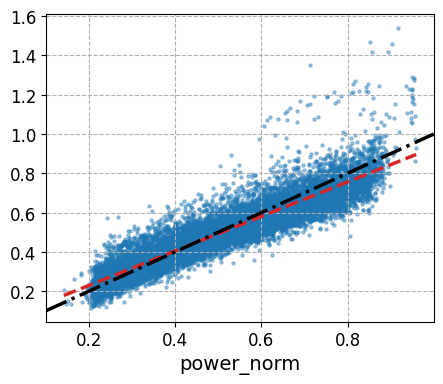

In [10]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.grid(ls='--')


# ax.plot(x_test, np.cos(np.deg2rad(x_test.numpy()))**3, ls='--', c='r')
sns.regplot(
    x=y_test,
    y=y_pred,
    # y=mean,
    scatter_kws=dict(
        s=5,
        alpha=.4,
        # edgecolor='.7'
    ),
    line_kws=dict(
        ls='--',
        lw=2.5,
        color='tab:red',
    )
)

ax.axline((.5, .5), slope=1, lw=2.5, ls='-.', c='k')

<Axes: xlabel='ws_norm', ylabel='power_norm'>

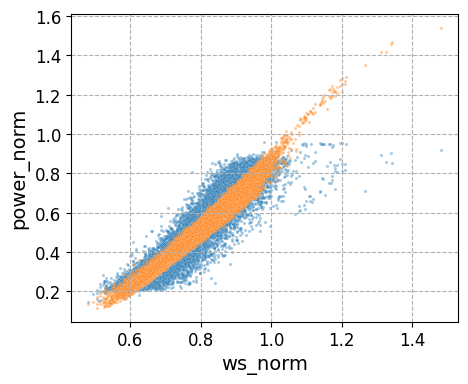

In [11]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.grid(ls='--')


# ax.plot(x_test, np.cos(np.deg2rad(x_test.numpy()))**3, ls='--', c='r')
sns.scatterplot(x=df['ws_norm'], y=df['power_norm'], s=5, alpha=.4, color='tab:blue')
sns.scatterplot(x=df['ws_norm'], y=y_pred, s=5, alpha=.4, color='tab:orange')


### Regressor for power ratio

In [12]:
df = (
    df
    .assign(power_expected=model.predict(df[features].values))
    .pipe(lambda df: (
        df.assign(
            power_ratio=df['power_norm'] / df['power_expected']
        )
    ))
)

<Axes: xlabel='yaw_err_center', ylabel='power_ratio'>

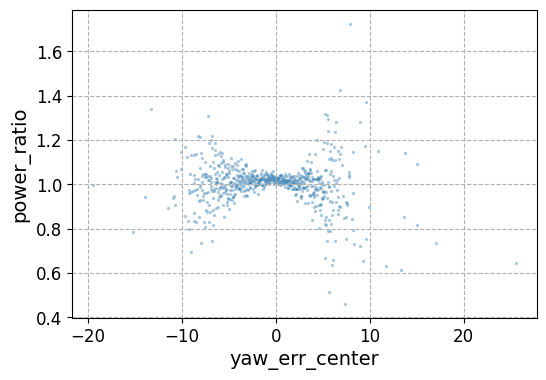

In [13]:
data = (
    df
    [['yaw_err_center', 'power_ratio']]
    .assign(
        yaw_bin=(df['yaw_err_center'] // .025) * .025
    )
    .groupby('yaw_bin')
    .mean()
)



_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')
sns.scatterplot(
    data=data,
    x='yaw_err_center',
    y='power_ratio',
    s=5,
    alpha=.4,
    edgecolor='.8',
)

In [22]:
model_ratio = SparseHSGPRegressor(
    n_pts=150,
    # preprocessor=MinMaxScaler(),
    objective='elbo',
    n_epochs=500,
    
)

model_ratio.fit(
    data[['yaw_err_center']].values,
    data['power_ratio'].values
)

07:58:14 INFO: Iter 10 of 500 - Loss: 15.966598510742188
07:58:14 INFO: Iter 20 of 500 - Loss: 3.1935958862304688
07:58:14 INFO: Iter 30 of 500 - Loss: 1.768985629081726
07:58:15 INFO: Iter 40 of 500 - Loss: 1.079821228981018
07:58:15 INFO: Iter 50 of 500 - Loss: 0.8173813223838806
07:58:15 INFO: Iter 60 of 500 - Loss: 0.6280142664909363
07:58:16 INFO: Iter 70 of 500 - Loss: 0.4835129380226135
07:58:16 INFO: Iter 80 of 500 - Loss: 0.36212730407714844
07:58:16 INFO: Iter 90 of 500 - Loss: 0.25618672370910645
07:58:16 INFO: Iter 100 of 500 - Loss: 0.16256237030029297
07:58:17 INFO: Iter 110 of 500 - Loss: 0.07894730567932129
07:58:17 INFO: Iter 120 of 500 - Loss: 0.0040212273597717285
07:58:17 INFO: Iter 130 of 500 - Loss: -0.060835301876068115
07:58:18 INFO: Iter 140 of 500 - Loss: -0.12225991487503052
07:58:18 INFO: Iter 150 of 500 - Loss: -0.17728590965270996
07:58:18 INFO: Iter 160 of 500 - Loss: -0.2265499234199524
07:58:18 INFO: Iter 170 of 500 - Loss: -0.27075880765914917
07:58:19

In [23]:
df[['yaw_err_center']].values

array([[ 1.80166667],
       [-1.8966666 ],
       [-0.3883334 ],
       ...,
       [-0.175     ],
       [ 2.06      ],
       [ 0.17      ]], shape=(14815, 1))

In [24]:
x = np.linspace(-7.5, 7.5, 101)

with torch.no_grad():
    f_dist = model_ratio.model(torch.tensor(x).to(torch.float32))

    y = f_dist.mean
    
    f_lower, f_upper = f_dist.confidence_region()
    # y_dist = likelihood(f_dist)
    # y_lower, y_upper = y_dist.confidence_region()

[Text(0.5, 0, '$\\Delta \\gamma\\; [deg]$'),
 (0.9, 1.1),
 Text(0, 0.5, '$P / P_{aligned}\\; [-]$')]

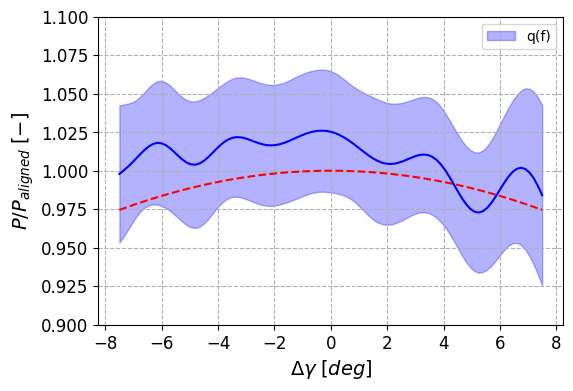

In [25]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')


ax.plot(x, np.cos(np.deg2rad(x))**3, ls='--', c='r')
line, = ax.plot(x, y, "blue")
ax.fill_between(x, f_lower, f_upper, color=line.get_color(), alpha=0.3, label="q(f)")
# ax.fill_between(x_test, y_lower, y_upper, color=line.get_color(), alpha=0.1, label="p(y)")
# ax.scatter(x_test, x_test, c='k', marker='.', label="Data")
ax.legend(loc="best")
ax.set(
    xlabel=r'$\Delta \gamma\; [deg]$',
    ylim=(.9, 1.1),
    ylabel=r'$P / P_{aligned}\; [-]$',
)